# Overview

In [43]:
import matplotlib as plt
import numpy as np
import pandas as pd


In [44]:
# data
df = pd.read_csv("..\data\cleaned.csv")

df.columns.tolist()
feats=['date_of_shout','time_of_shout',
'time_boat_launched',
'time_boat_returned',
'pager_code',
'what_three_words',
'location_of_shout',
'core_long_lat',
'adjustment_km',
'adj_long_lat',
'shout_details',
'shout_details_tags',
'crew_on_board',
'crew_on_shore',
'weather_at_time_of_shout']


# Date analysis


# Time analysis


In [45]:
feats=['time_of_shout','time_boat_launched','time_boat_returned']

dff=df[feats]
dff[dff["time_boat_returned"] == "00:00"].head()


,time_of_shout,time_boat_launched,time_boat_returned
87,13:15,00:00,00:00
142,12:05,12:05,00:00
143,14:48,15:00,00:00
144,20:56,21:10,00:00
145,22:22,22:35,00:00


In [46]:
# If "00:00" replace with none
# Replace "00:00" with NaN
dff['time_of_shout'].replace({"00:00": np.nan}, inplace=True)
dff['time_boat_launched'].replace({"00:00": np.nan}, inplace=True)
dff['time_boat_returned'].replace({"00:00": np.nan}, inplace=True)


C:\Users\RhysL\AppData\Local\Temp\ipykernel_12960\307799347.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dff['time_of_shout'].replace({"00:00": np.nan}, inplace=True)
C:\Users\RhysL\AppData\Local\Temp\ipykernel_12960\307799347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['time_of_shout'].replace({"00:00": np.nan}, inplace=Tru

In [47]:
# Determine rows where "time_of_shout" is null
# df[df["time_of_shout"].isna()]
# df[df["time_boat_launched"].isna()]

# df['time_of_shout'].value_counts()
# df['time_boat_launched'].value_counts() #0
# df["time_boat_returned"].value_counts() #20


# df[df["time_boat_returned"] == "00:00"].head()
# df[df["time_boat_returned"] == np.nan].head()

# dff=df[feats]
dff.head(88)



,time_of_shout,time_boat_launched,time_boat_returned
0,15:05,15:20,16:15
1,18:44,19:00,20:15
2,11:10,11:10,12:15
3,09:44,09:55,10:30
4,18:49,19:04,20:04
...,...,...,...
83,22:00,NaN,23:20
84,20:45,21:00,23:15
85,19:00,19:15,20:45
86,19:15,19:25,21:00


In [30]:
# time recorded as 16:04 format
df['time_of_shout'] = pd.to_datetime(df['time_of_shout'], format='%H:%M')
df['time_boat_launched'] = pd.to_datetime(df['time_boat_launched'], format='%H:%M')
df['time_boat_returned'] = pd.to_datetime(df['time_boat_returned'], format='%H:%M')

In [31]:
# determine time between "time_of_shout" and "time_boat_launched" if values are not NaN
df['difference_minutes_shout_launch'] = df.apply(
    lambda row: (row['time_boat_launched'] - row['time_of_shout']).total_seconds() / 60 
    if pd.notnull(row['time_of_shout']) and pd.notnull(row['time_boat_launched']) else np.nan, axis=1)

# determine time between "time_boat_launched" and "time_boat_returned" if values are not NaN
df['difference_minutes_launch_return'] = df.apply(
    lambda row: (row['time_boat_returned'] - row['time_boat_launched']).total_seconds() / 60 
    if pd.notnull(row['time_boat_launched']) and pd.notnull(row['time_boat_returned']) else np.nan, axis=1)

In [ ]:
# # dOnt want negative times, determine entry where are negative
# #for "difference_minutes_shout_launch" which are negative?
# df[df["difference_minutes_shout_launch"]<0].head()
# x=["difference_minutes_shout_launch","difference_minutes_launch_return"]
# df[x]
# #plot these values 
# df[x].plot(kind='box')

In [32]:
# Don't want negative times, determine entries where are negative
# For "difference_minutes_shout_launch" which are negative?
negative_diff = df[df["difference_minutes_shout_launch"] < 0]
if not negative_diff.empty:
    print("Negative differences found:")
    print(negative_diff.head())
else:
    print("No negative differences found.")

Negative differences found:
   date_of_shout       time_of_shout  time_boat_launched  time_boat_returned  \
14    14/06/2023 1900-01-01 19:15:00 1900-01-01 19:08:00 1900-01-01 21:15:00   
39    12/03/2023 1900-01-01 12:02:00 1900-01-01 10:30:00 1900-01-01 13:35:00   
80    19/08/2023 1900-01-01 16:45:00 1900-01-01 11:00:00 1900-01-01 17:00:00   
83    26/08/2023 1900-01-01 22:00:00 1900-01-01 00:00:00 1900-01-01 23:20:00   
87    15/08/2023 1900-01-01 13:15:00 1900-01-01 00:00:00 1900-01-01 00:00:00   

   pager_code what_three_words      location_of_shout  \
14        222              NaN        duck bay marina   
39        999              NaN  Duncan Mills Slip Way   
80        222              NaN                 Ardlui   
83        222              NaN             inchmurrin   
87        999              NaN                   Luss   

                             core_long_lat adjustment_km  adj_long_lat  \
14  56.015875525440634, -4.608751849497498           s,2           NaN   


In [ ]:

# Handle NaN values before plotting
df_filled = df.fillna(0)

x = ["difference_minutes_shout_launch", "difference_minutes_launch_return"]

# Plot these values 
df_filled[x].plot(kind='box')

In [ ]:
x=['time_of_shout','time_boat_launched',"difference_minutes_shout_launch",'time_boat_launched','time_boat_returned',"difference_minutes_launch_return"]
df[x].head()

,date_of_shout,time_of_shout,time_boat_launched,time_boat_returned,pager_code,what_three_words,location_of_shout,core_long_lat,adjustment_km,adj_long_lat,shout_details,shout_details_tags,crew_on_board,crew_on_shore,weather_at_time_of_shout,difference_minutes_shout_launch,difference_minutes_launch_return
14,14/06/2023,1900-01-01 19:15:00,1900-01-01 19:08:00,1900-01-01 21:15:00,222,NaN,duck bay marina,"56.015875525440634, -4.608751849497498","s,2",NaN,Crew were out on training when flagged down by...,"Medical, Transport","RB, ABS, DON, JB, EM, GD",NaN,"Sunny, dry",-7.0,127.0
39,12/03/2023,1900-01-01 12:02:00,1900-01-01 10:30:00,1900-01-01 13:35:00,999,NaN,Duncan Mills Slip Way,"56.00811093271105, -4.59079415208642",NaN,NaN,Crew made aware of two persons fallen into the...,"Search, Rescue","DON, GERARD ,AM , RO , PBT",NaN,"raining,light",-92.0,185.0
80,19/08/2023,1900-01-01 16:45:00,1900-01-01 11:00:00,1900-01-01 17:00:00,222,NaN,Ardlui,"56.05088096606834, -4.603218646384661",NaN,NaN,"Charity day, on return to Balloch we were info...","Mechanical, Rescue, Transport","ABS, TR, EM, DO",NaN,"Rain, stROng southerly wind",-345.0,360.0
83,26/08/2023,1900-01-01 22:00:00,1900-01-01 00:00:00,1900-01-01 23:20:00,222,NaN,inchmurrin,"56.05045207483461, -4.604535200252212","e,2",NaN,Whilst on previous shout we were made aware of...,Miscellaneous,"RB, DS, GH, CG","DON,JB","Flat light, misty",-1320.0,1400.0
87,15/08/2023,1900-01-01 13:15:00,1900-01-01 00:00:00,1900-01-01 00:00:00,999,NaN,Luss,"56.10297731643803, -4.637896988771806",NaN,NaN,Police Scotland tried to page us for cardiac a...,"Mechanical, Rescue, Transport",NaN,"RB, IG, TR, GH","Calm,close",-795.0,0.0


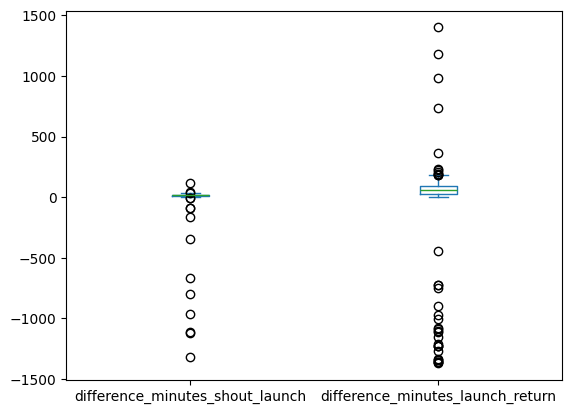


## Pager codes and length of time taken


In [ ]:



# Define the time range from 06:00 to 23:59
start_time = 6 * 60  # 06:00 in minutes
end_time = 23 * 60 + 59  # 23:59 in minutes

# Generate random data points within the time range
num_points = 40
np.random.seed(0)  # For reproducibility
data_point_times = np.random.uniform(start_time, end_time, num_points)
data_point_durations = np.random.randint(60, 180, num_points)  # Random durations between 60 and 180 minutes

# Plotting the line marking the time range
plt.axvline(x=start_time, color='gray', linestyle='--')
plt.axvline(x=end_time, color='gray', linestyle='--')

# Plotting the data points as bars
for time, duration in zip(data_point_times, data_point_durations):
    plt.bar(time, duration, color='red', width=10)  # Adjust width as needed

# Adding labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Duration (minutes)')
plt.title('Data Points within Time Range')

# Setting x-axis limits
plt.xlim(start_time, end_time)

# Display the plot
plt.show()


## Pager and times begun (boxplot)

## length of time and top 10 incidents? 



# Crew analysis



## crew appearances (numbers)

In [5]:
df.columns
feats=['date_of_shout','time_of_shout',
'time_boat_launched',
'time_boat_returned',
'pager_code',
'what_three_words',
'location_of_shout',
'core_long_lat',
'adjustment_km',
'adj_long_lat',
'shout_details',
'shout_details_tags',
'crew_on_board',
'crew_on_shore',
'weather_at_time_of_shout']


Index(['date_of_shout', 'time_of_shout', 'time_boat_launched', 'pager_code',
       'what_three_words', 'location_of_shout', 'Unnamed: 6', 'core_long_lat',
       'adjustment_km', 'adj_long_lat', 'shout_details', 'shout_details_tags',
       'crew_on_board', 'crew_on_shore', 'weather_at_time_of_shout'],
      dtype='object')

In [ ]:
coxswains=["RB","RO","IG","AM","ABS"]
satfy_advisors=["ABS","DON"]

# Example data as a list of comma-separated strings
data = ['AB,CD,EF', 'GH,IJ,KL', 'AB,CD,XY', 'AB,XY,CD', 'EF,CD,AB']
df["crew"]

def counter(given_initials, data):
    # Count the number of occurrences of the given set of initials
    dict={"999":0,"333":0,"222":0}
    count = 0
    for entry in data:
        if given_initials in entry:
            count += 1

    return dict

In [ ]:

#example
counter("RB", data)



## Crew and pager codes (partitioned bar graph - number of incidents attended)



In [ ]:
import matplotlib.pyplot as plt

# Data for the bar graph
categories = ['Category A', 'Category B', 'Category C']
values_part1 = [10, 15, 20]  # Values for part 1 of each category
values_part2 = [5, 10, 15]    # Values for part 2 of each category

# Colors for each part
colors_part1 = ['blue', 'green', 'red']
colors_part2 = ['lightblue', 'lightgreen', 'lightcoral']

# Plotting the bar graph
plt.figure(figsize=(8, 6))

plt.bar(categories, values_part1, color=colors_part1, label='Part 1')
plt.bar(categories, values_part2, color=colors_part2, label='Part 2', bottom=values_part1)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph Decomposed into Parts')
plt.legend()

# Display the plot
plt.show()

import pandas as pd

# Example data
data = {
    'Initials': ['AB,CD,EF', 'GH,IJ,KL', 'AB,CD,XY', 'AB,XY,CD', 'EF,CD,AB'],
    'Pager': [999, 333, 222, 999, 222]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Given set of initials to search for
given_initials = 'AB'

# Group by initials and collect pagers
grouped = df.groupby('Initials')['Pager'].apply(list).reset_index()

# Filter the DataFrame to get the pagers for the given set of initials
pagers = grouped[grouped['Initials'].str.contains(given_initials)]['Pager'].tolist()

print(f"The pagers for the given set of initials '{given_initials}' are:")
for pager_list in pagers:
    print(pager_list)


## Coxwains and who would be best to train next - experience




# Pager 



## (number of incidents in a date range) (spring/summer/autum/winter(barplot)


# shout tags


## shout tags - dates?

## shout tags and time taken.




